# Handcrafted model, Xception, Keras Tuner (KAGGLE VERSION)

In [33]:
!apt -y install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8

!pip uninstall -y tensorflow
!pip install tensorflow


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import shutil
from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from PIL import Image
import re
from IPython.display import FileLink
from tensorflow.keras import mixed_precision
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Enable experimental feature of memory occupation growth control 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Enable distributed training to use multiple GPUs
strategy = tf.distribute.MirroredStrategy()
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [34]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Metadata

In [35]:
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
batch_size = 32 * strategy.num_replicas_in_sync #Here we are using 32 batch size per GPU
epochs = 400
classes = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Prepare the environment

In [ ]:
path = os.getcwd()
if not os.path.exists(path+'/training_data_final'):
    shutil.copytree('../input/train-data-final/training_data_final', os.getcwd() + r'/training_data_final')
print(os.listdir(os.getcwd()))

In [37]:
train_split = 0.80

path = os.getcwd()
if not os.path.exists(path+'/training') and not os.path.exists(path+'/validation'):
    os.mkdir(path+'/training')
    os.mkdir(path+'/validation')

    # Destination path 
    dest_train = path + '/training'
    dest_valid = path + '/validation'

    # Source path
    source = path + '/training_data_final'

    # Create train and validation into the training and validation folders
    for folder in os.listdir(source):
        if not os.path.exists(dest_train + '/' + folder):
            os.mkdir(dest_train + '/' + folder)
        if not os.path.exists(dest_valid + '/' + folder):
            os.mkdir(dest_valid + '/' + folder)
    
        class_source = source + '/' + folder                                                   # Create path of the class
        files = os.listdir(class_source)                                                       # List of files for the class
        random.shuffle(files)
        
        # Create training set randomly
        for i in range(int(len(files) * train_split)):
            dest = shutil.copy(class_source+'/'+files[i], dest_train+'/'+folder+'/'+files[i])  # Copy an image in the training set
        
        # Create validation set randomly
        for j in range(i + 1, len(files)):
            dest = shutil.copy(class_source+'/'+files[j], dest_valid+'/'+folder+'/'+files[j])  # copy an image in the validation set

### Prepare the validation set for evaluation purposes

In [38]:
samples = []
targets = []

dest_valid = os.getcwd() + '/validation'

for folder in os.listdir(dest_valid):
    dest_class = dest_valid + '/' + folder
    i = int(re.sub("\D", "", folder)) - 1
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)

X_val = np.array(samples)
y_val = np.array(targets, dtype=np.uint8)
print(X_val.shape, X_val.dtype, sep=", ")
print(y_val.shape, y_val.dtype, sep=", ")

y_numeric = []
for v in y_val:
    y_numeric.append(np.argmax(v))

labels = np.unique(np.fromiter([np.argmax(t) for t in y_val], np.int32))

(713, 96, 96, 3), uint8
(713, 8), uint8


### Load training set to perform optional standardization during training

In [39]:
samples = []
targets = []

dest_train = os.getcwd() + '/training'

for folder in os.listdir(dest_train):
    dest_class = dest_train + '/' + folder
    i = int(re.sub("\D", "", folder)) - 1
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)
    
X_train = np.array(samples)
y_train = np.array(targets, dtype=np.uint8)
print(X_train.shape, X_train.dtype, sep=", ")
print(y_train.shape, y_train.dtype, sep=", ")


(2829, 96, 96, 3), uint8
(2829, 8), uint8


In [40]:
#shutil.rmtree("/kaggle/working/training_aug")   #Uncomment this if you want to rebuild the training_aug

### Static training set imbalance to perform oversampling of minority class (NO AUGMENTATION HERE)

In [41]:
use_original_training = False   #If true, no oversampling will be applied
balanced = True #If true, training set images will be duplicated to get same amount of samples from each class. 
                #If false, trainingset will be imbalanced to get a sampling frequency that matches class_weights
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_numeric)))  #Compute class weights using scikit library


if  not os.path.exists(path+'/training_aug'):
    old_train = os.getcwd() + '/training'
    dest_train = os.getcwd() + '/training_aug'
    shutil.copytree(old_train, dest_train) #Copy the previous training set folder images into new inflated training folder

    static_gen = ImageDataGenerator()
    if not use_original_training:
        #find folder with largest number of samples
        folder_sizes = []
        for folder in os.listdir(dest_train):
            dest_path = dest_train + '/' + folder
            folder_sizes.append(len(os.listdir(dest_path)))
        print(folder_sizes)
        desired_amount = np.max(folder_sizes)
        print("Target: "+ str(desired_amount) + " images per class")
        label = 0
        for folder in os.listdir(dest_train):
            dest_path = dest_train + '/' + folder

            if balanced:
                to_produce = desired_amount - len(os.listdir(dest_path))
            else:
                to_produce = desired_amount - len(os.listdir(dest_path)) + int((max(class_weights[label],1) - 1) * desired_amount)
            
            static_gen_data = static_gen.flow_from_directory(dest_train,
                                                            batch_size=1,
                                                            target_size=input_size,
                                                            classes=[folder],
                                                            class_mode='categorical',      # Targets are directly converted into one-hot vectors
                                                            shuffle=False,                 # Shuffle set to false to try to duplicate images from the same class the same number of times
                                                            seed=seed) 

            print(f'Computing {to_produce} augmented images for target "{folder}"')
            os.chdir(dest_path)
            for i in range(0, to_produce):
                Image.fromarray(np.squeeze(next(static_gen_data)[0]).astype(np.uint8)).save(f'aug{i:05}.jpg')
            os.chdir('../')
            label += 1

    os.chdir('../')
    print('\n' + os.getcwd())

### Online augmentation
Lets create the generators we'll need...

In [42]:

#from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import preprocess_input
#defining optional preprocess function, note: high cpu usage causes bottleneck
def preprocess_custom(image):
    image = tf.image.random_contrast(image, 0.99, 1.01)
    image = tf.image.random_saturation(image, 0.85, 1.15)
    image = tf.image.random_hue(image, 0.1)
    return preprocess_input(image)

In [43]:
#Apply online augmentation and apply network's preprocessing function

train_data_gen = ImageDataGenerator(rotation_range = 90,
                                    height_shift_range = 30,
                                    width_shift_range = 30,
                                    channel_shift_range= 35,
                                    horizontal_flip = True,
                                    shear_range=5,
                                    zoom_range=[0.6,1.6], # added zoom range
                                    fill_mode = 'reflect',
                                    brightness_range=[0.8,1.2],
                                    featurewise_center=False, 
                                    featurewise_std_normalization=False,
                                    preprocessing_function = preprocess_input)
#train_data_gen.fit(preprocess_input(X_train)) # uncomment this to fit the training generator to the non augmented training set to learn mean and std
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    featurewise_center=False, 
                                    featurewise_std_normalization=False)
#valid_data_gen.fit(preprocess_input(X_train)) # uncomment this to fit the validation generator to the non augmented training 
print(train_data_gen.mean,train_data_gen.std)
#Note, to use standardization featurewise_center,featurewise_std_normalization must be True in both train and validation generators

None None


... using flow_from_directory

In [44]:
# Paths
path = os.getcwd()
training_dir = path + '/training_aug'
validation_dir = path + '/validation'

# Training
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=batch_size,
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)  

# Validation
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=batch_size, 
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed)

# Create Datasets objects
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

valid_dataset = valid_dataset.repeat()

Found 3432 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


### Handcrafted model 

In [45]:
def build_handcrafted_model(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(input_layer)
    
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    #x = tfkl.Dropout(0.2, seed=seed, name='gap_dropout')(x)

    # end of convolutional layers
    # start of the fully connected layers
    
    x = tfkl.Flatten()(x)
    
    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense1')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense2')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense3')(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense4')(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense5')(x)
    
    x = tfkl.Dropout(0.2, seed=seed, name='dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'conv_dense_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


### Build the model

In [46]:
# first convolutional model
with strategy.scope():   
    model = build_handcrafted_model(input_shape)

    model.summary()

Model: "conv_dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 256)       7168      
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 256)       0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 256)       590080    
                                                                 
 mp2 (MaxPooling2D)          (None, 24, 24, 256)       0         
                                                                 
 Conv3 (Conv2D)              (None, 24, 24, 256)       590080    
                                                                 
 gap (GlobalAveragePooling2D  (None, 256)         

In [47]:
# training
#Note that we are now getting a lower training and validation accuracies than the ones we got at the start of the project using this model. This is probably
#caused by the fact that at that time we were using offline augmentation, so training set was easier to explain
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_numeric)))
history = model.fit(x=train_dataset,
                    epochs=epochs,                                    
                    steps_per_epoch=len(train_gen),   # 1 epoch will be considered as 1 pass over the training augmented dataset. Thanks to inflated training set we perform oversampling
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    class_weight=class_weights,                       #Class weights not used in the loss function during supernet tuning
                    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/400


2022-11-27 16:24:32.337031: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:242"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



54/54 [==============================] - ETA: 0s - loss: 2.4775 - accuracy: 0.1308

2022-11-27 16:24:59.083955: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:245"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



54/54 [==============================] - 29s 281ms/step - loss: 2.4775 - accuracy: 0.1308 - val_loss: 2.2003 - val_accuracy: 0.0631
Epoch 2/400
54/54 [==============================] - 15s 287ms/step - loss: 2.2842 - accuracy: 0.1503 - val_loss: 2.1403 - val_accuracy: 0.1641
Epoch 3/400
54/54 [==============================] - 15s 281ms/step - loss: 2.1809 - accuracy: 0.1891 - val_loss: 2.0959 - val_accuracy: 0.2637
Epoch 4/400
54/54 [==============================] - 15s 289ms/step - loss: 2.0599 - accuracy: 0.2381 - val_loss: 1.8206 - val_accuracy: 0.2903
Epoch 5/400
54/54 [==============================] - 16s 291ms/step - loss: 1.9698 - accuracy: 0.2788 - val_loss: 1.7948 - val_accuracy: 0.2847
Epoch 6/400
54/54 [==============================] - 15s 280ms/step - loss: 1.8846 - accuracy: 0.3202 - val_loss: 1.7117 - val_accuracy: 0.2623
Epoch 7/400
54/54 [==============================] - 16s 297ms/step - loss: 1.8593 - accuracy: 0.3345 - val_loss: 1.7547 - val_accuracy: 0.3240
Epoc

### Plot training results

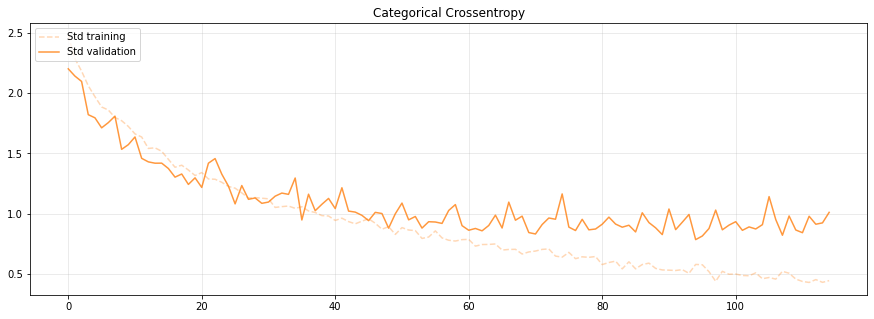

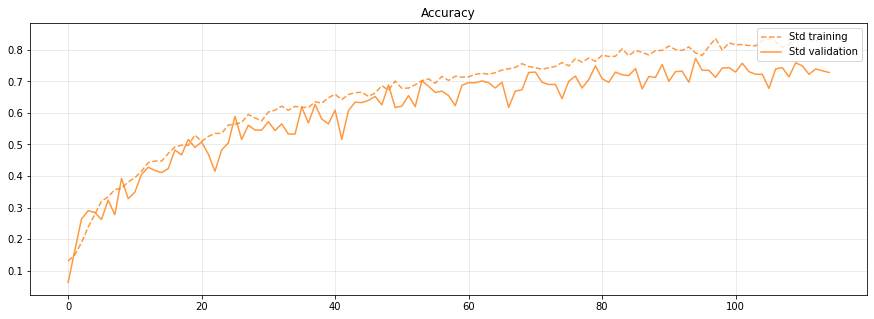

In [48]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

2022-11-27 16:55:04.282233: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 78852096 exceeds 10% of free system memory.
2022-11-27 16:55:04.402735: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 78852096 exceeds 10% of free system memory.
2022-11-27 16:55:04.492407: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 78852096 exceeds 10% of free system memory.


23/23 [==============================] - 2s 13ms/step
Accuracy: 0.7728
Precision: 0.7602
Recall: 0.7582
F1: [0.46   0.8257 0.8223 0.7553 0.8194 0.814  0.9143 0.62  ]


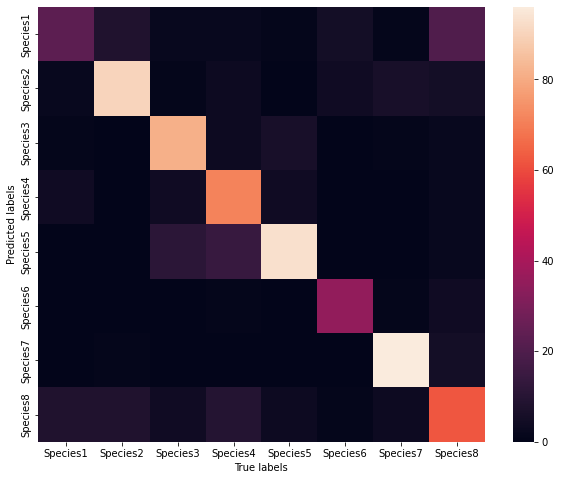

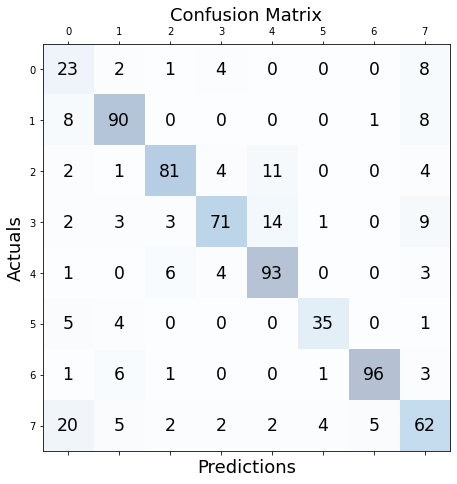

In [49]:
predictions = model.predict(preprocess_input(X_val))
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Print the confusion matrix using Matplotlib
conf_matrix = confusion_matrix(y_true=np.argmax(y_val, axis=-1), y_pred= np.argmax(predictions, axis=-1))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Build the supernet model for tuning

Note that the notebook outputs of the following models are not 100% related to the parameters shown here. For example, outputs have been generated using 20 patience instead of 30-35 that was used when building the final model

In [50]:
def build_supernet_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=(192,192,3))  #Specify the new shape
    l2_lambda = 0.005
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Resizing(192, 192, interpolation="bicubic", name='resizing')(input_layer)  #applying the resizing

    x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x = tfkl.Dropout(0.45, seed=seed)(x) 
    
    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'conv_dense_model_v1_online')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(2e-4), metrics='accuracy')

    # Return the model
    return model

### Define the model

In [51]:
with strategy.scope():        #Build the model inside the mirror strategy scope
    model = build_supernet_model(input_shape)
    # Enable the tuning to the whole supernet 
    model.get_layer('xception').trainable = True
    
    #for i, layer in enumerate(model.get_layer('xception').layers[:-10]):
    #  layer.trainable=False
    
    for i, layer in enumerate(model.get_layer('xception').layers):
       print(i, layer.name, layer.trainable)  
    
    model.summary()

83683744/83683744 [==============================] - 1s 0us/step
0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True

### Train the model

In [53]:
#exponential decay for the learning rate
initial_lr = 2e-4 
def scheduler(epoch, lr):
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * tf.math.exp(- (epoch-10) / 10.0)


# Train the network
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_numeric)))

history = model.fit(x=train_dataset,
                    epochs=epochs,                                    
                    steps_per_epoch=2*len(train_gen),   # 1 epoch will be considered as 2 pass over the training augmented dataset. Thanks to inflated training set we perform oversampling
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    class_weight=class_weights,                       
                    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
                                tfk.callbacks.LearningRateScheduler(scheduler)]
).history

Epoch 1/400


2022-11-27 16:55:13.234830: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:242"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}

2022-11-27 16:56:02.907012: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which 

108/108 [==============================] - ETA: 0s - loss: 1.4964 - accuracy: 0.5122

2022-11-27 16:57:01.081387: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:245"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



108/108 [==============================] - 114s 418ms/step - loss: 1.4964 - accuracy: 0.5122 - val_loss: 1.2274 - val_accuracy: 0.5666 - lr: 2.0000e-04
Epoch 2/400
108/108 [==============================] - 38s 355ms/step - loss: 0.8661 - accuracy: 0.7303 - val_loss: 0.8292 - val_accuracy: 0.7588 - lr: 2.0000e-04
Epoch 3/400
108/108 [==============================] - 39s 362ms/step - loss: 0.6705 - accuracy: 0.7992 - val_loss: 0.6193 - val_accuracy: 0.8275 - lr: 2.0000e-04
Epoch 4/400
108/108 [==============================] - 38s 355ms/step - loss: 0.5450 - accuracy: 0.8395 - val_loss: 0.6407 - val_accuracy: 0.8219 - lr: 2.0000e-04
Epoch 5/400
108/108 [==============================] - 39s 366ms/step - loss: 0.4753 - accuracy: 0.8582 - val_loss: 0.7071 - val_accuracy: 0.7826 - lr: 2.0000e-04
Epoch 6/400
108/108 [==============================] - 39s 363ms/step - loss: 0.4104 - accuracy: 0.8820 - val_loss: 0.5308 - val_accuracy: 0.8597 - lr: 2.0000e-04
Epoch 7/400
108/108 [============

### Plot training results

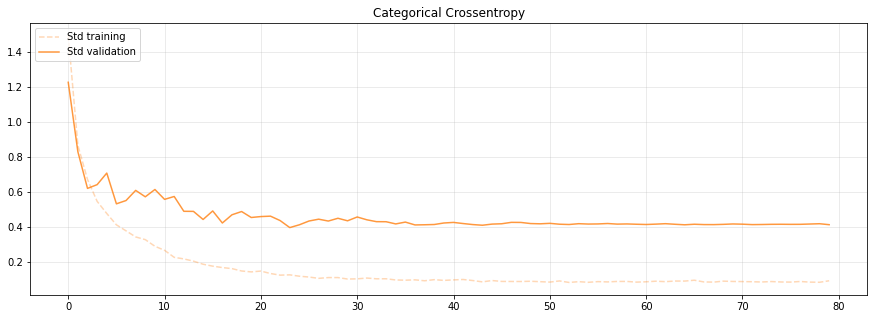

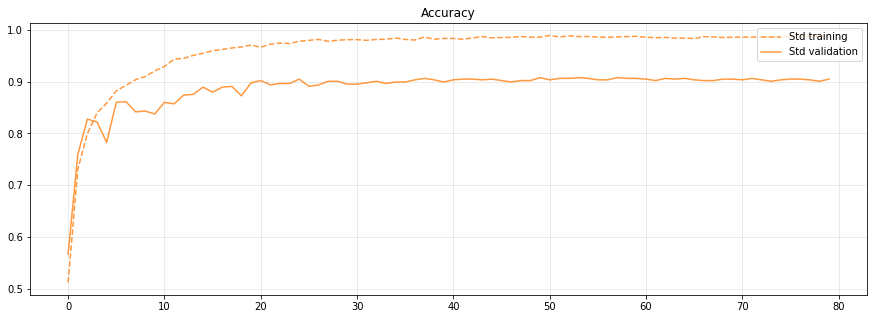

In [54]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

2022-11-27 17:47:55.447372: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 78852096 exceeds 10% of free system memory.
2022-11-27 17:47:55.558473: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 78852096 exceeds 10% of free system memory.


23/23 [==============================] - 4s 32ms/step
Accuracy: 0.9032
Precision: 0.9043
Recall: 0.8631
F1: [0.5357 0.9058 0.9209 0.9032 0.9238 0.9535 0.972  0.8683]


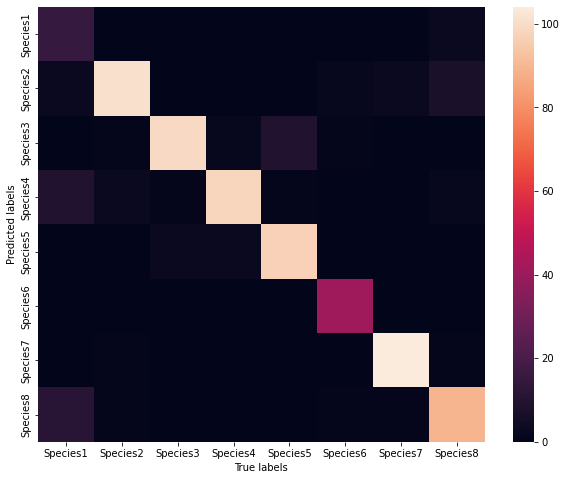

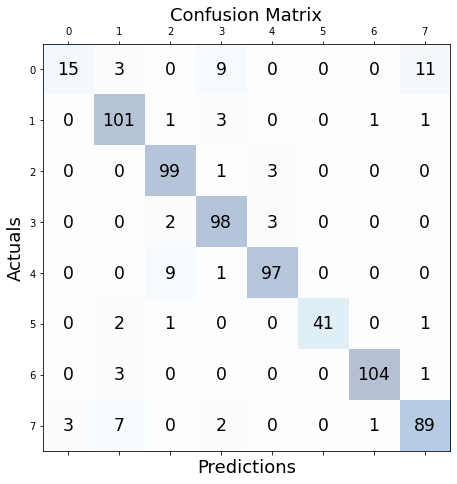

In [55]:
predictions = model.predict(preprocess_input(X_val))
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Print the confusion matrix using Matplotlib
conf_matrix = confusion_matrix(y_true=np.argmax(y_val, axis=-1), y_pred= np.argmax(predictions, axis=-1))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Save the model

In [56]:
supernet_name = "supernet_xcept_balanced" + str(accuracy.round(5))
supernet_name_dir = supernet_name + "_dir"
model.save(supernet_name, include_optimizer=False)

shutil.copytree(supernet_name, supernet_name_dir + '/' + supernet_name)

shutil.make_archive(supernet_name_dir, 'zip', supernet_name_dir)
FileLink(supernet_name_dir+'.zip') #Get link to download the zip file of the model

/kaggle/working/supernet_xcept_balanced0.90323_dir.zip

### Testing the Keras hyperband tuner

In [61]:

def build_tuner_model(hp):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(include_top=False,
                                            input_shape=(192,192,3))  
    
    # Recover previous weights
    supernet.set_weights(tfk.models.load_model(supernet_name).get_layer('xception').get_weights()) #Loading previous saved supernet fine-tuned model

    l2_lambda = hp.Float('l2_lambda', min_value=0.001, max_value=0.01, step=0.002)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Resizing(192, 192, interpolation="bicubic", name='resizing')(input_layer)
    
    x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    hp_drop = hp.Choice('dropout', values=[0.3, 0.4, 0.45, 0.5, 0.55])    
    
    x = tfkl.Dropout(hp_drop, seed=seed)(x)
    
    hp_units1 = hp.Choice('units_dense_1', values=[2048, 1024, 512, 256, 128])
    x = tfkl.Dense(
        units = hp_units1,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        name = 'classifier2')(x)
    
    x = tfkl.Dropout(hp_drop, seed=seed)(x)
    
    hp_units2 = hp.Choice('units_dense_2', values=[2048, 1024, 512, 256, 128])    
    
    x = tfkl.Dense(
        units = hp_units2,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        name = 'classifier3')(x)
    
    x = tfkl.Dropout(hp_drop, seed=seed)(x)

    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'classifier_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(2e-4), metrics='accuracy')
    
    model.get_layer('xception').trainable = False

    # Return the model
    return model 

Note that the following output is a partial execution of the tuner

In [67]:
import keras_tuner as kt

initial_lr = 2e-4 
def scheduler(epoch, lr):
    if epoch <20:
        return initial_lr
    elif epoch % 15 == 0:
        return lr*0.8
    return max(lr,8e-6) 
#setup tuner

tuner = kt.Hyperband(build_tuner_model,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='/kaggle/working/',
                     distribution_strategy = strategy,  #Apply mirror strategy during the tuning to use both gpus
                     project_name='param_tuning')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

tuner.search(x=train_dataset,
             steps_per_epoch=len(train_gen),
             validation_data=valid_dataset,
             validation_steps=len(valid_gen),
             class_weight=class_weights,
             epochs=30, 
             callbacks=[stop_early,tfk.callbacks.LearningRateScheduler(scheduler)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
0.003             |0.007             |l2_lambda
0.45              |0.55              |dropout
2048              |512               |units_dense_1
512               |512               |units_dense_2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


2022-11-27 17:52:40.422204: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:242"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}

2022-11-27 17:53:30.081839: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which 

54/54 [==============================] - ETA: 0s - loss: 15.2357 - accuracy: 0.8534

2022-11-27 17:54:07.402567: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:245"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



54/54 [==============================] - 94s 483ms/step - loss: 15.2357 - accuracy: 0.8534 - val_loss: 14.7433 - val_accuracy: 0.8359 - lr: 2.0000e-04
Epoch 2/2
 9/54 [====>.........................] - ETA: 11s - loss: 14.0131 - accuracy: 0.9514

KeyboardInterrupt: 

## Build the final classifier

In [68]:
def build_classifier_model(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(include_top=False,
                                            input_shape=(192,192,3))
    
    # Recover previous weights
    supernet.set_weights(tfk.models.load_model(supernet_name).get_layer('xception').get_weights())  #Here we load the weights of the supernet previously trained

    l2_lambda = 0.01
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Resizing(192, 192, interpolation="bicubic", name='resizing')(input_layer)
    
    x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    hp_drop = 0.55   
    
    x = tfkl.Dropout(hp_drop, seed=seed)(x)

    
    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        name = 'classifier2')(x)

    x = tfkl.Dropout(hp_drop, seed=seed)(x)
        
    
    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        name = 'classifier3')(x)

    x = tfkl.Dropout(hp_drop, seed=seed)(x)

    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tfk.regularizers.L2(l2_lambda),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'classifier_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
    

    # Return the model
    return model

In [69]:
with strategy.scope():
    classifier_model = build_classifier_model(input_shape)

    # Use the supernet as a pretrained feature extraction net (and apply eventual fine tuning)
    classifier_model.get_layer('xception').trainable = False
    #for i, layer in enumerate(classifier_model.get_layer('xception').layers[:-10]):
    #  layer.trainable=False
    for i, layer in enumerate(classifier_model.get_layer('xception').layers):
       print(i, layer.name, layer.trainable)  

    classifier_model.summary()

0 input_2 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_4 False
13 block2_pool False
14 batch_normalization_4 False
15 add_12 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_5 False
23 block3_pool False
24 batch_normalization_5 False
25 add_13 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_6 False
33 block4_pool False
34 batch_normalization_6 False
35 add_14 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepco

Note that in the following output is shown an example of a run which leads to a lower result with respect to the one of the submitted model. Performance of the classifier depends on the loaded supernet too.
Parameters could be slightly different too. In previous tests our model was able to reach Validation Accuracy: 0.92006

In [70]:
#exponential decay for the learning rate
initial_lr = 1e-4 
def scheduler(epoch, lr):
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * tf.math.exp(- (epoch-10) / 20.0)

class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_numeric)))

classifier_history = classifier_model.fit(x=train_dataset,
                                          epochs=epochs,                                  
                                          steps_per_epoch=len(train_gen),
                                          validation_data=valid_dataset,
                                          validation_steps=len(valid_gen),
                                          class_weight=class_weights,
                                          callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
                                                       tfk.callbacks.LearningRateScheduler(scheduler)]
).history

Epoch 1/400


2022-11-27 17:54:43.935984: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:242"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



54/54 [==============================] - ETA: 0s - loss: 21.9625 - accuracy: 0.4551

2022-11-27 17:56:11.750296: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:245"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



54/54 [==============================] - 93s 434ms/step - loss: 21.9625 - accuracy: 0.4551 - val_loss: 20.3670 - val_accuracy: 0.8850 - lr: 1.0000e-04
Epoch 2/400
54/54 [==============================] - 19s 360ms/step - loss: 19.9412 - accuracy: 0.8348 - val_loss: 19.3077 - val_accuracy: 0.8934 - lr: 1.0000e-04
Epoch 3/400
54/54 [==============================] - 20s 372ms/step - loss: 18.7456 - accuracy: 0.9175 - val_loss: 18.3249 - val_accuracy: 0.8808 - lr: 1.0000e-04
Epoch 4/400
54/54 [==============================] - 20s 374ms/step - loss: 17.6302 - accuracy: 0.9318 - val_loss: 17.2886 - val_accuracy: 0.8878 - lr: 1.0000e-04
Epoch 5/400
54/54 [==============================] - 21s 391ms/step - loss: 16.4891 - accuracy: 0.9496 - val_loss: 16.2357 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 6/400
54/54 [==============================] - 20s 366ms/step - loss: 15.3891 - accuracy: 0.9534 - val_loss: 15.2077 - val_accuracy: 0.8920 - lr: 1.0000e-04
Epoch 7/400
54/54 [===============

### Plot training results

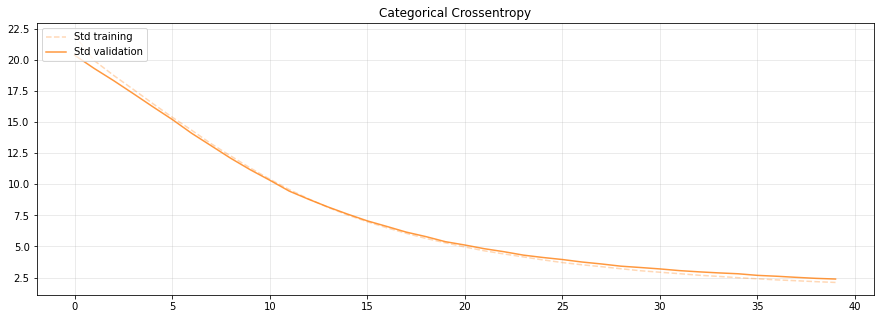

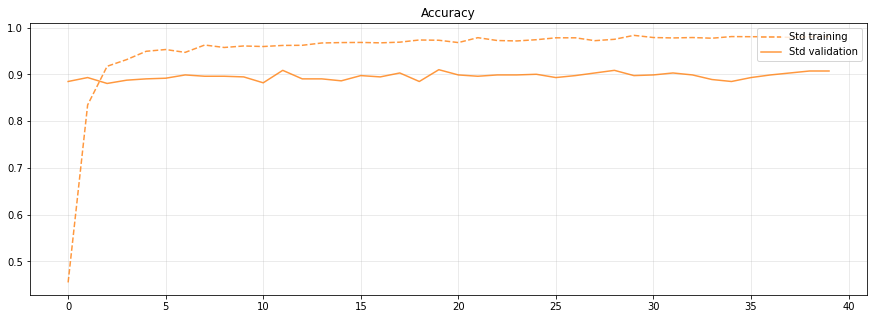

In [71]:
history = classifier_history

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

23/23 [==============================] - 4s 35ms/step
Accuracy: 0.9102
Precision: 0.9082
Recall: 0.8753
F1: [0.6    0.9182 0.9302 0.9151 0.934  0.9535 0.9581 0.8738]


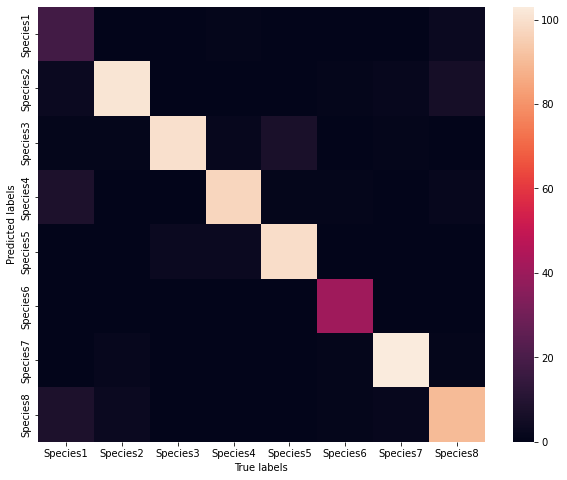

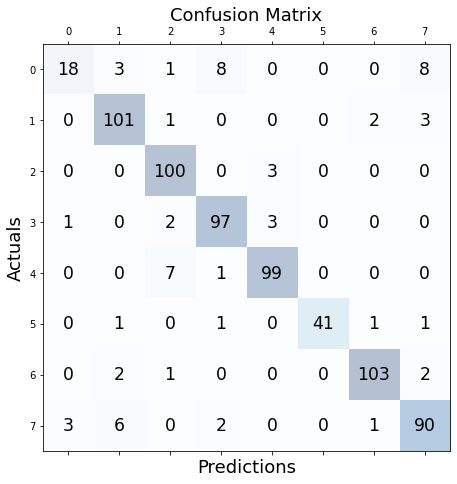

In [72]:
predictions = classifier_model.predict(preprocess_input(X_val))
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Print the confusion matrix using Matplotlib
conf_matrix = confusion_matrix(y_true=np.argmax(y_val, axis=-1), y_pred= np.argmax(predictions, axis=-1))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Save the model

In [ ]:
classifier_name = "classifier_0.01_0.55_lr20_35color_" + str(accuracy.round(5))
classifier_name_dir = classifier_name + "_dir"
classifier_model.save(classifier_name, include_optimizer=False)

shutil.copytree(classifier_name, classifier_name_dir + '/' + classifier_name)

shutil.make_archive(classifier_name_dir, 'zip', classifier_name_dir)
FileLink(classifier_name_dir+'.zip')


Link to one of the two Xception model used in the ensemble: https://polimi365-my.sharepoint.com/:u:/g/personal/10687747_polimi_it/EbdOOWAYyYZNmMOfaHE5J1kBtWl7WsxQr441z2wgymO1iQ?e=dWJbgP